In [7]:
%matplotlib inline

In [8]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv

from const import STATE, COLORS, NUM_STATES,  STATES


In [9]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

infection_factor = 1.999881671966743

In [11]:
total_days = 480
def one_run(days_before_lift):
    alpha_list = [
        (0, params_before.alpha),
        (days_before_ld, params_after.alpha),
        (days_before_lift, params_before.alpha)
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_ld, params_after.beta),
        (days_before_lift, params_before.beta)
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_ld, days_before_lift],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0
    )

    total, _, _, r0_info = do_simulation(total_days, bed_info, p)
    return days_before_lift, total, r0_info

In [12]:
days_list = np.arange(150, 361, step=30)
rows = Parallel(n_jobs=-1)(delayed(one_run)(days) for days in days_list)

days = 150
[2.6510649337996512, 1.9976418850689885, 4.939072696641898]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']


/home/cloud-user/code/covid-19/helpers.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

days = 180
[2.6510649337996512, 1.9941967257197222, 4.938870055970682]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']
days = 210
[2.6510649337996512, 1.9929818194696207, 4.938853908724483]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']
days = 240
[2.6510649337996512, 1.9925367152837339, 4.9387369422097205]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']
days = 270
[2.6510649337996512, 1.992373973666501, 4.938837342142358]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']
days = 300
[2.6510649337996512, 1.9923211475696787, 4.938822624725638]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']
days = 330
[2.6510649337996512, 1.9923038834514186, 4.943889636745876]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']
days = 360
[2.6510649337996512, 1.9922982374228757, 4.3463865338898735]
['29/11/19' '04/03/20' '08/06/20' '12/09/20' '17/12/20' '23/03/21']


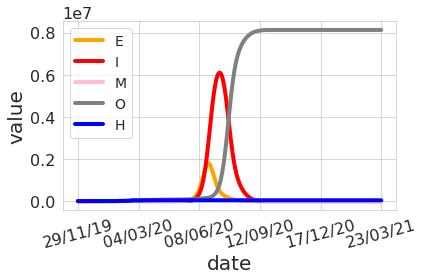

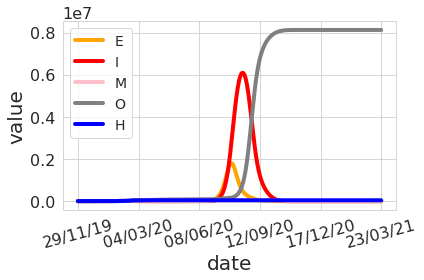

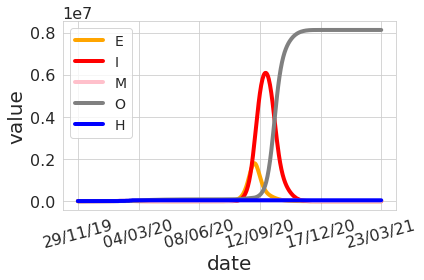

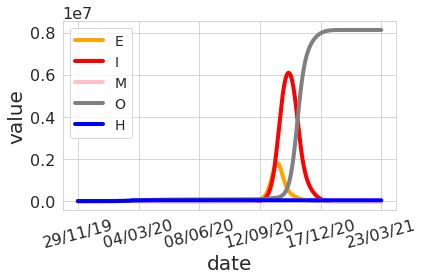

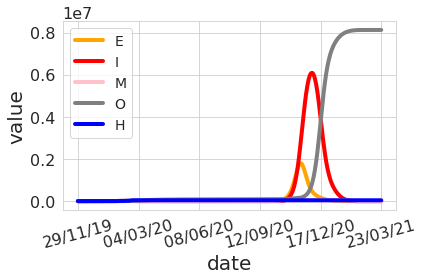

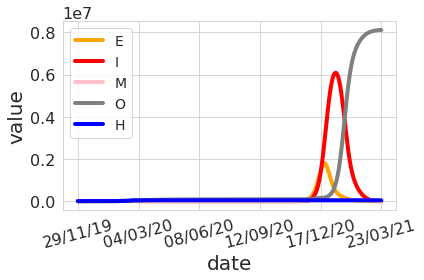

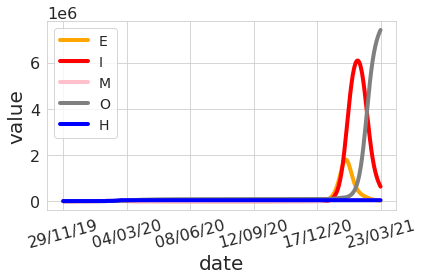

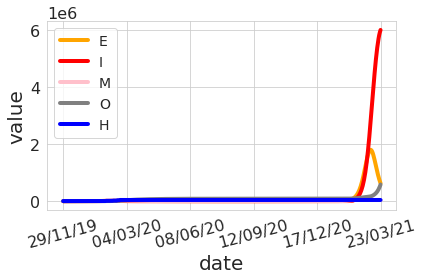

In [13]:
r0_rows = []
for days, total, r0_info in rows:    
    print('days =', days)
    r0_row = [t[-1] for t in r0_info.values()]
    print(r0_row)
    r0_rows.append([days] + r0_row)
    fig, ax = plot_total(total, p0_time,  total_days)
    fig.savefig(f'figs/lift-lockdown/{days}.pdf')
    total_to_csv(p0_time, total_days, total, f'output/tbl/lift-lockdown/{days}.csv')

In [14]:
df = pd.DataFrame(r0_rows, columns=['factor', 'before-ld', 'after-ld', 'after-ld-lift'])
df.to_csv('output/tbl/lift-lockdown/r0.csv', index=None)
df

,factor,before-ld,after-ld,after-ld-lift
0,150,2.651065,1.997642,4.939073
1,180,2.651065,1.994197,4.938870
2,210,2.651065,1.992982,4.938854
3,240,2.651065,1.992537,4.938737
4,270,2.651065,1.992374,4.938837
5,300,2.651065,1.992321,4.938823
6,330,2.651065,1.992304,4.943890
7,360,2.651065,1.992298,4.346387
